In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Image
import scipy.io
import pandas as pd
from IPython.display import display, clear_output
import sys, os
import warnings
import h5py

warnings.filterwarnings('ignore')
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from scipy import linalg
import itertools
%matplotlib inline
from aidapy import load_data
import aidapy.aidaxr
from scipy.interpolate import griddata
from sklearn import mixture
from scipy.ndimage import gaussian_filter

In [2]:
### parameters inizialization ###

#set time
start_time = datetime(2015, 10, 16, 13, 7, 0);
end_time   = datetime(2015, 10, 16, 13, 8, 0);

#choose mms probe
probes= 3

#various
vmax = 600

#dimension of interpolation grid
grid_dim=50

#h5py file name
filename = 'outto_tst.h5'

#max components for gmm
n_components_range= 15

#number of generated particles from vdf
n_part=40000

#choose between bic or aic
information_criterion='bic'

In [3]:
### write vtk file for paraview ###
def write_vtk(ds_arr,x,y,z,itime):
    [nx, ny, nz] = np.shape(ds_arr)
    a=nx*ny*nz
    f = open(''+str(information_criterion)+'/VTK_data'+str(itime)+'.vtk','w') # change your vtk file name
    f.write('# vtk DataFile Version 2.0\n')
    f.write('test\n')
    f.write('ASCII\n')
    f.write('DATASET STRUCTURED_POINTS\n')
    f.write('DIMENSIONS '+str(nx)+' '+str(ny)+' '+str( nz)+'\n') # change your dimension
    f.write('SPACING '+ str(x[1,0,0]-x[0,0,0]) +' ' + str(y[0,1,0]-y[0,0,0]) +' ' + str(z[0,0,1]-z[0,0,0]) +'\n')
    f.write('ORIGIN '+ str(x[0,0,0]) +' ' + str(y[0,0,0]) +' ' + str(z[0,0,0]) +'\n')
    f.write('POINT_DATA '+str(nx*ny*nz)+'\n') # change the number of point data
    f.write('SCALARS VDF float\n')
    f.write('LOOKUP_TABLE default\n')
    #f.close()
    #f = open('VTK_data3.vtk','ab') # change your vtk file name
    #f.write(ds_arr.tobytes())
    #out=ds_arr.flatten()
    #out.tofile(f)
    #ds_arr.ndarray.tofile(f, sep='', format='%s')
    for i in range(0,nx):
        for j in range(0,ny):
            for k in range(0,nz):
                content = str(ds_arr[i,j,k])
                f.write(content+'\n')
    f.close()
    return

In [6]:
### download data  ###
settings = {'prod': ['i_dist'],
            'probes': probes, 'coords': 'gse', 'mode': 'high_res', 'frame':'gse'}

xr_mms = load_data(mission='mms', start_time=start_time, end_time=end_time, **settings)

In [7]:
#physical quantities
mi = 1.67e-27
e = 0.5*mi*(vmax*1e3)**2
e = e/(1.6e-19)

#utility strings
phistr='mms{}_dis_phi_brst'.format(probes)
thetastr='mms{}_dis_theta_brst'.format(probes)
energystr='mms{}_dis_energy_brst'.format(probes)
fpistr='i_dist{}'.format(probes)

In [8]:
### cartesian fpi ###

fpi=np.array(xr_mms[fpistr])
phi=np.array(xr_mms[phistr]/360*2*np.pi)
theta=np.array(xr_mms[thetastr]/360*2*np.pi)
energy=np.array(xr_mms[energystr])

tt=np.array(xr_mms['time1']).astype('<i8')

v =np.sqrt(2/mi*energy*(1.6e-19)) *1e-3

fiv, thv, vv = np.meshgrid(phi, theta, v,  indexing='ij')
vxv = vv * np.cos (fiv) * np.sin (thv)
vyv = vv * np.sin (fiv) * np.sin (thv)
vzv = vv * np.cos (thv)

# print('vxv',np.min(vxv),np.max(vxv))
# print('vyv',np.min(vyv),np.max(vyv))
# print('vzv',np.min(vzv),np.max(vzv))

points=np.column_stack((vxv.ravel(), vyv.ravel(), vzv.ravel()))

vx = np.linspace(-vmax, vmax, grid_dim)

grid_x, grid_y, grid_z= np.meshgrid(vx,vx,vx, indexing='ij')

Nx,Ny,Nz= grid_x.shape
Ntimes=fpi.shape[0]
fpicart=np.zeros((Ntimes,Nx,Ny,Nz))

for itime in range(0, Ntimes):
    fpi1=fpi[itime,:].ravel()
    fpicart[itime,:,:,:] = griddata(points, fpi1, (grid_x, grid_y, grid_z), method='linear')
    
    ### writing vtk file with distributions for paraview ###
    #write_vtk(fpicart[itime,:,:,:],grid_x, grid_y, grid_z,itime)

print(Ntimes)

293


In [8]:
### write h5py file with data and cartesian interpolation ###
file = h5py.File(filename,'w')
size = fpi.shape
file.create_dataset('fpi',size,data=fpi)
size = phi.shape
file.create_dataset('phi',size,data=phi)
size = theta.shape
file.create_dataset('theta',size,data=theta)
size = energy.shape
file.create_dataset('energy',size,data=energy)
size = grid_x.shape
file.create_dataset('grid_x',size,data=grid_x)
size = grid_y.shape
file.create_dataset('grid_y',size,data=grid_y)
size = grid_z.shape
file.create_dataset('grid_z',size,data=grid_z)
size = fpicart.shape
file.create_dataset('fpcart',size,data=fpicart)
size = tt.shape
file.create_dataset('times',size,'<i8',data=tt)
file.close()

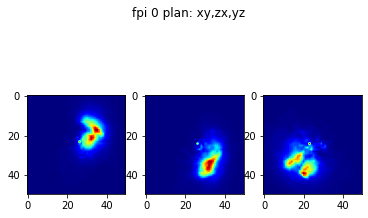

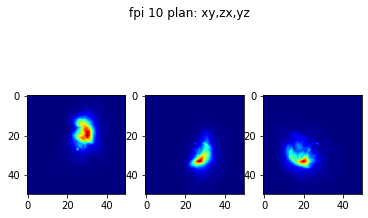

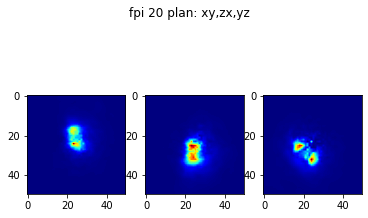

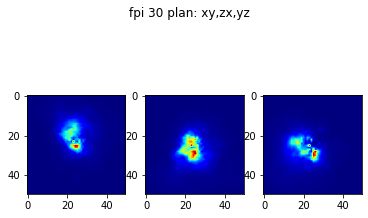

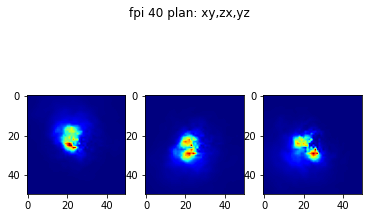

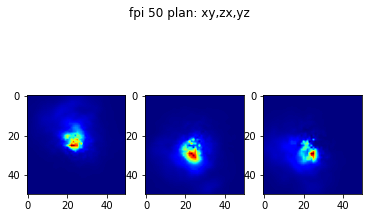

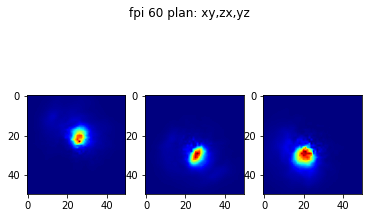

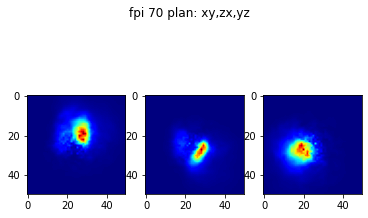

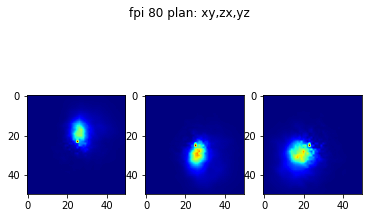

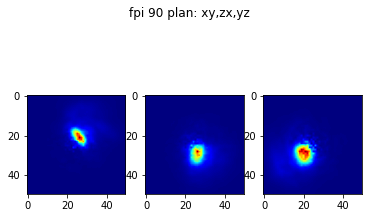

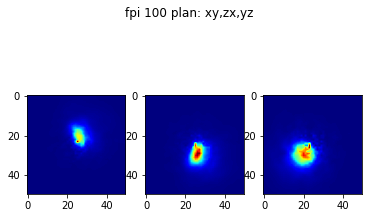

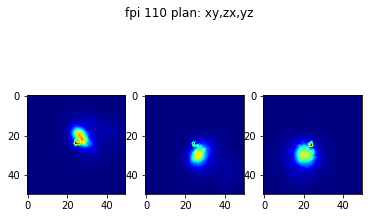

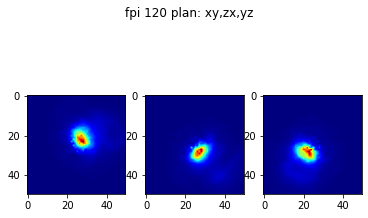

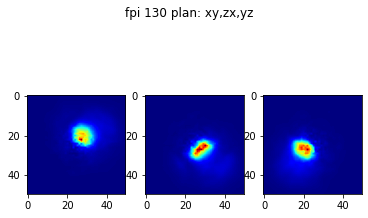

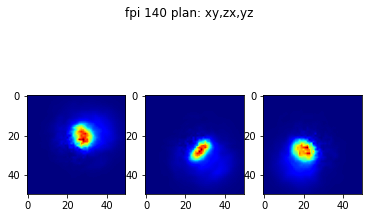

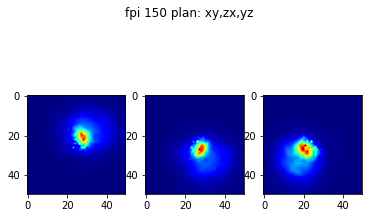

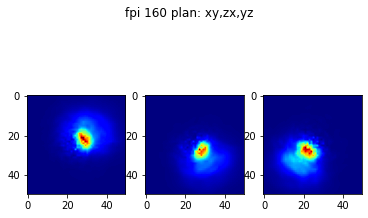

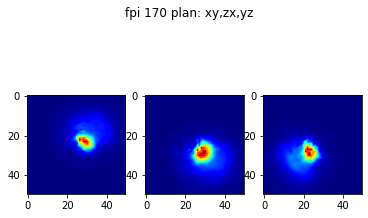

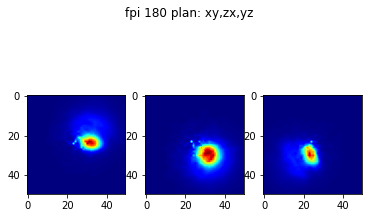

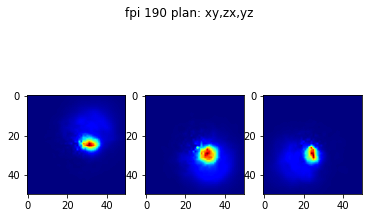

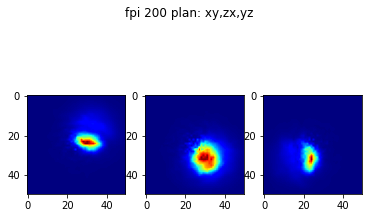

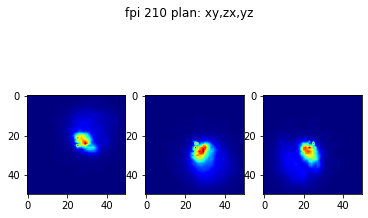

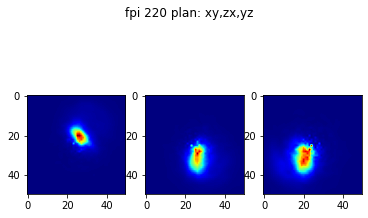

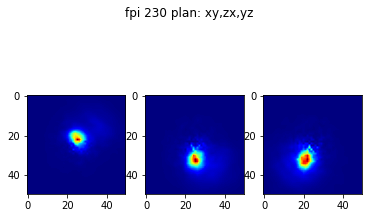

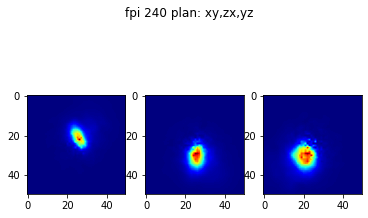

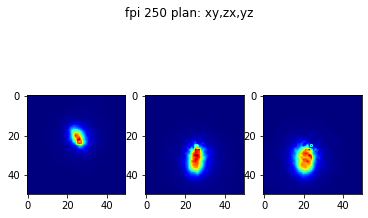

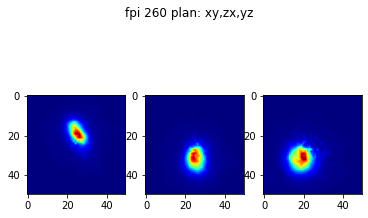

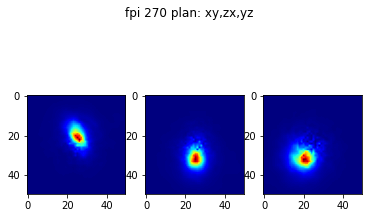

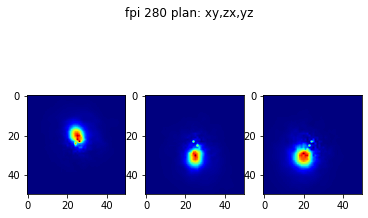

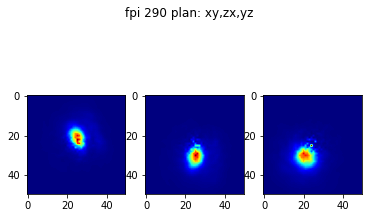

In [9]:
### various vdf plots ###

### plot distribution cuts ###
#fcut=fpicart[0,:,:,:]

### plot a cut ###
# zcut=int(fcut.shape[2]/2)
# fplan=fcut[:,:,zcut]
# # x = np.arange(0,fcut.shape[0])
# # y = np.arange(0,fcut.shape[1])
# scat=plt.imshow(fplan, cmap='viridis')
# plt.imshow(fplan, cmap='viridis')
# plt.colorbar(scat)
# plt.show

# step=10
# for cut in range(0, fcut.shape[0], step):
#     plt.imshow(fcut[:,:,cut], cmap='viridis')
#     plt.colorbar(scat)
#     clear_output(wait = True)
#     plt.pause(1)

### plot integrating over 1 axis ###
for i in range (0,Ntimes,10):
    fcut=fpicart[i,:,:,:]
    ftot1=np.sum(fcut, axis=0)
    ftot2=np.sum(fcut, axis=1)
    ftot3=np.sum(fcut, axis=2)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle('fpi '+str(i)+' plan: xy,zx,yz')
    ax1.imshow(ftot1, cmap='jet')
    ax2.imshow(ftot2, cmap='jet')
    ax3.imshow(ftot3, cmap='jet')
    #plt.colorbar(scat)

# ax1.axis([20, 80, 20, 80])
# ax2.axis([20, 80, 20, 80])
# ax3.axis([20, 80, 20, 80])

probe: 3 vdf: 0 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 1 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 2 n_particles: 40000 info: bic gmm: 11 tied
probe: 3 vdf: 3 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 4 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 5 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 6 n_particles: 40000 info: bic gmm: 12 tied
probe: 3 vdf: 7 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 8 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 9 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 10 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 11 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 12 n_particles: 40000 info: bic gmm: 12 tied
probe: 3 vdf: 13 n_particles: 40000 info: bic gmm: 13 tied
probe: 3 vdf: 14 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 15 n_particles: 40000 info: bic gmm: 12 tied
probe: 3 vdf: 16 n_particles: 40000 info: bic gmm: 14 tied
probe: 

probe: 3 vdf: 139 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 140 n_particles: 40000 info: bic gmm: 13 tied
probe: 3 vdf: 141 n_particles: 40000 info: bic gmm: 13 tied
probe: 3 vdf: 142 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 143 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 144 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 145 n_particles: 40000 info: bic gmm: 12 tied
probe: 3 vdf: 146 n_particles: 40000 info: bic gmm: 13 tied
probe: 3 vdf: 147 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 148 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 149 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 150 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 151 n_particles: 40000 info: bic gmm: 13 tied
probe: 3 vdf: 152 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 153 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 154 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 155 n_particles: 40000 inf

probe: 3 vdf: 276 n_particles: 40000 info: bic gmm: 13 tied
probe: 3 vdf: 277 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 278 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 279 n_particles: 40000 info: bic gmm: 13 tied
probe: 3 vdf: 280 n_particles: 40000 info: bic gmm: 13 tied
probe: 3 vdf: 281 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 282 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 283 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 284 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 285 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 286 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 287 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 288 n_particles: 40000 info: bic gmm: 13 tied
probe: 3 vdf: 289 n_particles: 40000 info: bic gmm: 13 tied
probe: 3 vdf: 290 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 291 n_particles: 40000 info: bic gmm: 14 tied
probe: 3 vdf: 292 n_particles: 40000 inf

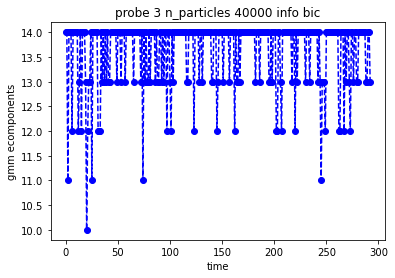

In [13]:
nx,ny,nz=fpicart.shape[1],fpicart.shape[2],fpicart.shape[3]
nclusters_plot=[]
info_plot=[]

### particle generation from vdf ###
for i in range (0, Ntimes):
    vdf=fpicart[i,:,:,:]
    vmax=600
    dv= 2*vmax/(nx-1)
    v1D= np.arange(-vmax,vmax+dv,dv)
    vvx,vvy,vvz= np.meshgrid(v1D,v1D,v1D)
    Np=n_part

    f1D=vdf.flatten()
    fmin= min([j for j in f1D if j>0])

    f1D= np.where(f1D==0, fmin/1000, f1D)

    vx1D=(np.conjugate(vvx).T).flatten()
    vy1D=(np.conjugate(vvy).T).flatten()
    vz1D=(np.conjugate(vvz).T).flatten()

    np.random.seed(0)
    Ng=f1D.shape[0]
    ranarr=np.random.rand(4,Np)
    fcum=np.cumsum(f1D);

    fcum=Ng*fcum/fcum[Ng-1]

    NgRange=np.arange(1,Ng+1)

    Pg=np.interp(Ng*ranarr[0,:], fcum.T, NgRange)
    Pg= 1 + np.floor(Pg)
    Pg=Pg.astype(int)

    xp=vx1D[Pg] + dv*ranarr[1,:] - dv/2
    yp=vy1D[Pg] + dv*ranarr[2,:] - dv/2
    zp=vz1D[Pg] + dv*ranarr[3,:] - dv/2
    
    #store data for gmm 
    gmmdata=np.array([xp,yp,zp])
    gmmdata=np.conjugate(gmmdata).T

    ### gmm ###
    lowest_info_crit = np.infty
    info_crit= []
    
    for n_components in range (1, n_components_range):

        gmm = GaussianMixture(n_components,covariance_type='tied' ,reg_covar=0.1, init_params='kmeans', random_state=0).fit(gmmdata)
        if (information_criterion=='aic'): info_crit.append(gmm.aic(gmmdata)) 
        elif (information_criterion=='bic'): info_crit.append(gmm.bic(gmmdata)) 
        
        if info_crit[-1] < lowest_info_crit:
                lowest_info_crit = info_crit[-1]
                best_gmm = gmm
    
    info_crit = np.array(info_crit)
    color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
    clf = best_gmm
    bars = []


    fcm_labels = best_gmm.predict(gmmdata)
    
    
#     ### Plot clusters ###
#     fig = plt.figure(figsize=(12, 12))
#     ax = fig.add_subplot(projection='3d')
#     ax.scatter(xp,yp,zp,marker='.', c=(fcm_labels+1))
#     plt.show()

#     ### Plot the bic/aic scores ###
#     plt.figure(figsize=(8, 6))
#     spl = plt.subplot(2, 1, 1)
#     for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
#         xpos = np.array(n_components_range) + 0.2 * (i - 2)
#         bars.append(
#             plt.bar(
#                 xpos,
#                 info_crit[i * len(n_components_range) : (i + 1) * len(n_components_range)],
#                 width=0.2,
#                 color=color,
#             )
#         )
#     plt.xticks(n_components_range)
#     plt.ylim([info_crit.min() * 1.01 - 0.01 * info_crit.max(), info_crit.max()])
#     plt.title(information_criterion+" score per model")
#     xpos = (
#         np.mod(info_crit.argmin(), len(n_components_range))
#         + 0.65
#         + 0.2 * np.floor(info_crit.argmin() / len(n_components_range))
#     )
#     plt.text(xpos, info_crit.min() * 0.97 + 0.03 * info_crit.max(), "*", fontsize=14)
#     spl.set_xlabel("Number of components")
#     spl.legend([b[0] for b in bars], cv_types)
#     plt.show()

    nclusters_plot.append(best_gmm.n_components)
    info_plot.append(info_crit)
    print('probe:',probes, 'vdf:',i,'n_particles:',n_part,'info:',information_criterion,'gmm:',best_gmm.n_components, best_gmm.covariance_type)

plt.clf()        
plt.plot(nclusters_plot,'bo--')
plt.title('probe '+str(probes)+' n_particles '+str(n_part)+' info '+information_criterion)
plt.ylabel('gmm ecomponents')
plt.xlabel('time')
plt.show()

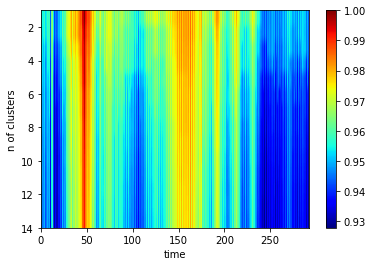

In [14]:
### plot aic/bic slope ###
cf=plt.imshow(np.transpose(info_plot)/np.amax(info_plot), origin = 'upper', extent=[0,itime,14,1], cmap='jet', aspect='auto')

plt.xlabel('time')
plt.ylabel('n of clusters')
# plt.colorbar(cf,format='%.10f')
plt.colorbar()